<a href="https://colab.research.google.com/github/nyluje/RCP209DeeplabExperiment/blob/main/RCP209_Project_2022_Deeplab_Experiment_With_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Import des librairies utilisées dans le projet

Au moment de la réalisation du projet l'environnement par défaut du service Google Colab utilisé les versions suivantes des librairies:

* `numpy version 1.21.5`
* `matplotlib version 3.2.2`
* `torch version 1.10.0+cu111`
* `torchvision version 0.11.1+cu111`
* `python version 3.7.13 (default, Mar 16 2022, 17:37:17) [GCC 7.5.0]`



In [13]:
#import des librairie utilisée

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
from torch.nn import parameter
from torch import cuda
from torch.utils.data import DataLoader, Subset
import torch.optim as optim


import torchvision
from torchvision.datasets import VOCSegmentation
from torchvision import transforms as T, models
#import torchsummary
#from torchsummary import summary

import os
import time
import datetime
import random
import sys

print(f'numpy version {np.__version__}')
print(f'matplotlib version {matplotlib.__version__}')
print(f'torch version {torch.__version__}')
print(f'torchvision version {torchvision.__version__}')
print(f'python version {sys.version}')

numpy version 1.21.5
matplotlib version 3.2.2
torch version 1.10.0+cu111
torchvision version 0.11.1+cu111
python version 3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]


# Importation du modèle Deeplab v3 de la librairie Torchvision

Pour l'exemple, le modèle `deeplabv3_mobilenet_v3_large` est utilisé.

Il est contruit en trois parties:
* Le `backbone` correspond au modèle de classification de base, avec des poids pré-entrainés, connecté au `classifier`, et aux différents `aux_classifier`;
* Le `classifier` donne le résultat en sortie de la classification par pixel;
* Le `aux_classifier` est un classifieur auxiliaire, comme dans le modèle GoogleLeNet. Il peut être utilisé dans l'entrainement des poids pour prendre en compte des couches intermédiaires du modèle.

## Couche `backbone` (Tansfer learning)

En entrée, le backbone est prévu pour recevoir un tenseur de taille 3 (les 3 couleurs RGB de l'image), composé pour chacun des canaux de couleur de la surface intégrale, en hauteur et largeur, de l'image d'origine. Une convolution de taille 3x3 est appliquée.
```
  (0): ConvNormActivation(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
```

En sortie du backbone, la 17ème couche fourni un tenseur de taille 960.
```
  (16): ConvNormActivation(
    (0): Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(960, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
```

## Couche `classifier` (classifieur final)

La première couche à l'intérieur de `classifier` est constitué des éléments de pooling pyramidale à trou, elle reçoit un tenseur de taille 960. En entrée (couche (0)), sur le modèle de l'inception, 5 opérations sont opérées sur le même tenseur de taille 960:
* une convolution 1x1
* une convolution à trou de taille 3x3 avec une dilatation (un espace entre les élément de la feature map utilisée) de taille 12
* une convolution à trou de taille 3x3 avec une dilatation de taille 24
* une convolution à trou de taille 3x3 avec une dilatation de taille 36
* Et une couche de pooling

Les 5 tenseurs partagent la même taille de sortie: 256. Chacun de ces tenseur de sortie permet de capter des caractéristiques de la feature map d'entrée à différente échelle.

```
  (0): ASPP(
    (convs): ModuleList(
      (0): Sequential(
        (0): Conv2d(960, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): ASPPConv(
        (0): Conv2d(960, 256, kernel_size=(3, 3), stride=(1, 1), padding=(12, 12), dilation=(12, 12), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): ASPPConv(
        (0): Conv2d(960, 256, kernel_size=(3, 3), stride=(1, 1), padding=(24, 24), dilation=(24, 24), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): ASPPConv(
        (0): Conv2d(960, 256, kernel_size=(3, 3), stride=(1, 1), padding=(36, 36), dilation=(36, 36), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (4): ASPPPooling(
        (0): AdaptiveAvgPool2d(output_size=1)
        (1): Conv2d(960, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU()
      )
    )
```

Les 5 tenseurs de taille 256 sont concatenés en un tenseur de taille 1280 qui sert d'input à la couche suivant. Les poids associés à cette couche vont permettre de pondéré l'interprétation des différentes échelles.
```
    (project): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace=False)
    )
```

En sortie, un tenseur de taille 21 est rendu, correspondant au 21 classes. Si le modèle devait être modifié pour classer un nombre différent de classes que le 21 classes du jeu de données Pascal VOC, il faudrait modifier la taille de cette sortie.
```
  (4): Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))
```

## Couche `aux_classifier` (classifieur auxiliaire)

Concernant le classifieur auxiliaire, il est à noté qu'il prend en entrée un tenseur de taille 40, ce qui permet de déduire qu'il doit être connecté à des couches du backbone donnant en sortie cette taille là (c'est le cas pour la 6ème couche et 7ème couche du backbone, indexées 5 et 6).
```
  (0): Conv2d(40, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
```

En sortie, le classifieur auxiliaire donne un tenseur de taille 21 (nombre de classes de Pascal VOC), comme pour le classifieur final, il faudrait modifier cette taille de sortie s'il était souhaité modifier les l'objet du classifieur.
```
  (4): Conv2d(10, 21, kernel_size=(1, 1), stride=(1, 1))
```


In [14]:

#importation d'un model deeplab prédéfini
model_dl=models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True,progress=False)

#https://github.com/pytorch/vision/blob/main/torchvision/models/segmentation/deeplabv3.py definition 
"""
        backbone (nn.Module): the network used to compute the features for the model.
            The backbone should return an OrderedDict[Tensor], with the key being
            "out" for the last feature map used, and "aux" if an auxiliary classifier
            is used.
        classifier (nn.Module): module that takes the "out" element returned from
            the backbone and returns a dense prediction.
        aux_classifier (nn.Module, optional): auxiliary classifier used during training
"""

#backbone correspondond au modèle de base, 
print("\r\n")
print("***** backbone layers *****")
print(f"base model backbone, on top of wich DeepLab is built is composed of {model_dl.backbone.__len__()} layers")
print("\r\n")
print(model_dl.backbone)

#classifier concerne la partie deeplab: DeepLabHead dans laquelle on retrouve la convolution à trou
print("\r\n")
print("***** classifier layers *****")
print(f"classifier is composed of {model_dl.classifier.__len__()} layers")
print("\r\n")
#print(model_dl.classifier[model_dl.classifier.__len__()-1])
print(model_dl.classifier)


#et également aux classifier
print("\r\n")
print("***** auxiliary Classifier layers *****")
print(f"auxiliary classifier is composed of {model_dl.aux_classifier.__len__()} layers")
print("\r\n")
print(model_dl.aux_classifier)





***** backbone layers *****
base model backbone, on top of wich DeepLab is built is composed of 17 layers


IntermediateLayerGetter(
  (0): ConvNormActivation(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (1): InvertedResidual(
    (block): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): ConvNormActivation(
        (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
    )
  )
  (2): InvertedResidual(
    (block): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(1

# Fonctions pour bloquer le calcul de gradient

L'objectif des quelques fonctions ci-dessous est de permettre de bloquer les calcul du gradient

In [15]:



#fonction pour bloquer ou libérer le calcul de gradient d'un model ou d'une partie d'un model
#def set_parameters_requires_grad(model,req_grad):
def set_parameters_requires_grad(model,req_grad,set_to_zero_weight):
    for param in model.parameters():
      param.requires_grad = req_grad
    for name, param in model.named_parameters():
      if set_to_zero_weight is True:
        param.data.fill_(0.01)


#fonction pour compter les paramètres bloqués ou non d'un model ou d'une partie d'un model
def display_count_grad_val_true_and_false_parameters(model):
  count_true=0
  count_false=0
  for param in model.parameters():
    if param.requires_grad is True:
      count_true+=1
    else:
      count_false+=1
  print(f'On model {model.__class__.__name__}, alterable gradient parameters number is {count_true},blocked gradient parameters number is: {count_false}')


#fonction pour bloquer les paramètres du modèle
def block_parameters_in_layers(model,backbone_layers_to_set_loose=0,aux_classifier_layers_to_set_loose=0,classifier_layers_to_set_loose=0,set_to_zero_weight=False,rewind_from_final_layer=True):
  block_parameters=True
  backbone_number_of_layers= model.backbone.__len__()
  aux_classifier_number_of_layers= model.aux_classifier.__len__() 
  classifier_number_of_layers= model.classifier.__len__() 
  #print(f"backbone_number_of_layers {backbone_number_of_layers}, aux_classifier_number_of_layers {aux_classifier_number_of_layers} , classifier_number_of_layers {classifier_number_of_layers}")

  if (backbone_layers_to_set_loose<=backbone_number_of_layers)&(aux_classifier_layers_to_set_loose<=aux_classifier_number_of_layers)&(classifier_layers_to_set_loose<=classifier_number_of_layers):
    set_parameters_requires_grad(model.backbone,False,False)
    set_parameters_requires_grad(model.aux_classifier,False,False)  
    set_parameters_requires_grad(model.classifier,False,False)  

    if rewind_from_final_layer is False:
      #Selection au hasard des couches sur lesquels les paramètres de gradient seront débloqués pour mise à jour possible
      layers_to_set_loose_on_backbone = np.random.choice(np.arange(backbone_number_of_layers), backbone_layers_to_set_loose, replace=False)
      layers_to_set_loose_on_classifier = np.random.choice(np.arange(classifier_number_of_layers), classifier_layers_to_set_loose, replace=False)
      layers_to_set_loose_on_aux_classifier = np.random.choice(np.arange(aux_classifier_number_of_layers), aux_classifier_layers_to_set_loose, replace=False)
    else:
      layers_to_set_loose_on_backbone = np.flip(np.arange(backbone_number_of_layers))[0:backbone_layers_to_set_loose]
      layers_to_set_loose_on_classifier = np.flip(np.arange(classifier_number_of_layers))[0:classifier_layers_to_set_loose]
      layers_to_set_loose_on_aux_classifier = np.flip(np.arange(aux_classifier_number_of_layers))[0:aux_classifier_layers_to_set_loose]
  
    for ltslob in layers_to_set_loose_on_backbone: set_parameters_requires_grad(model.backbone[str(ltslob)],True, set_to_zero_weight)
    for ltsloc in layers_to_set_loose_on_classifier: set_parameters_requires_grad(model.classifier[ltsloc],True,  set_to_zero_weight)
    for ltsloac in layers_to_set_loose_on_aux_classifier: set_parameters_requires_grad(model.aux_classifier[ltsloac],True,set_to_zero_weight)  

  else:
    raise Exception(f"Number of layers required to set loose is more than availabe in one of the 3 main layers, backbone_layers_to_set_loose: {backbone_layers_to_set_loose} , backbone_number_of_layers: {backbone_number_of_layers} ; aux_classifier_to_set_loose: {aux_classifier_to_set_loose} , aux_classifier_number_of_layers: {aux_classifier_number_of_layers} ; classifier_layers_to_set_loose: {classifier_layers_to_set_loose} , classifier_number_of_layers: {classifier_number_of_layers}")





In [16]:

display_count_grad_val_true_and_false_parameters(model_dl.backbone)
display_count_grad_val_true_and_false_parameters(model_dl.classifier)
display_count_grad_val_true_and_false_parameters(model_dl.aux_classifier)


print("-"*10)


block_parameters_in_layers(model_dl,backbone_layers_to_set_loose=1,aux_classifier_layers_to_set_loose=0,classifier_layers_to_set_loose=1,set_to_zero_weight=False)

display_count_grad_val_true_and_false_parameters(model_dl.backbone)
display_count_grad_val_true_and_false_parameters(model_dl.classifier)
display_count_grad_val_true_and_false_parameters(model_dl.aux_classifier)


On model IntermediateLayerGetter, alterable gradient parameters number is 170,blocked gradient parameters number is: 0
On model DeepLabHead, alterable gradient parameters number is 23,blocked gradient parameters number is: 0
On model FCNHead, alterable gradient parameters number is 5,blocked gradient parameters number is: 0
----------
On model IntermediateLayerGetter, alterable gradient parameters number is 3,blocked gradient parameters number is: 167
On model DeepLabHead, alterable gradient parameters number is 2,blocked gradient parameters number is: 21
On model FCNHead, alterable gradient parameters number is 0,blocked gradient parameters number is: 5


# Chargement du jeu de données Pascal VOC

## Fonction pour identifier la hauteur et largeur maximum

Cette fonction permet de déterminer la largeur maximum à utiliser

In [17]:
#cette fonction détermine les différences de taille hauteur et largeur de chaque 
def min_pad_to_apply_based_on_image_set(voctocheck, verbose=True):
  max_height=0
  max_width=0
  min_height=0
  min_width=0
  min_pad_on_width=0
  min_pad_on_height=0
  min_pad=0

  start_time = time.time()
  for i in range(0,voctocheck.__len__()):
    min_height = voctocheck[i][0].height if voctocheck[i][0].height<min_height or min_height==0 else min_height
    min_width = voctocheck[i][0].width if voctocheck[i][0].width<min_width or min_width==0 else min_width
    max_height = voctocheck[i][0].height if voctocheck[i][0].height>max_height else max_height
    max_width = voctocheck[i][0].width if voctocheck[i][0].width>max_width else max_width
    min_pad_on_height=max_height-min_height
    min_pad_on_width=max_width-min_width
    min_pad = min_pad_on_width if min_pad_on_width>min_pad_on_height else min_pad_on_height
  total_time= time.time()-start_time
  total_time_str=str(datetime.timedelta(seconds=int(total_time)))
  if verbose: 
    print(f'Time to iterate thru  was: {total_time_str}')
    print(f'max_height: {max_height}, max_width: {max_width}, min_height: {min_height}, min_width: {min_width}, min_pad_on_height: {min_pad_on_height}, min_pad_on_width: {min_pad_on_width},  min_pad: {min_pad}')
  return int(min_pad/2)

In [18]:

dataset_dir_root="/content/drive/MyDrive/RCP209/datasets"
specific_dataset_dir='VOCdevkit'
vocDevkitNeedToBeDownloaded = not os.path.isdir(os.path.join(dataset_dir_root,specific_dataset_dir))

"""
vocSegDatasetTrain = VOCSegmentation(root=datasetDirRoot,image_set='train',year='2012'
                                ,download=vocDevkitNeedToBeDownloaded
                                )
print(vocSegDatasetTrain.__len__())
pic = vocSegDatasetTrain.__getitem__(100)
showImageReady(pic[1])
showImageReady(pic[0])
dataloaderTrain = DataLoader(vocSegDatasetTrain,batch_size=4,shuffle=True)
"""

voctocheck = VOCSegmentation(root=dataset_dir_root,year='2012'
                                ,download=vocDevkitNeedToBeDownloaded)

apply_parsing_of_image_set=False
min_pad_to_apply = (min_pad_to_apply_based_on_image_set(voctocheck) if apply_parsing_of_image_set==True else 194)


#pour pouvoir les grouper par batch 
#(c'est à dire: plusieurs images dans un même tenseur dont la première dimension correspond au nombre d'image dans le batch)
#les images seront toutes transformées (déformées) avec la taille standard de 500 sur 500 pixels              
base_size=500 
transform_to_apply_on_input_data=T.Compose(
                                    [
                                     T.Pad(min_pad_to_apply,fill=255),
                                     T.CenterCrop(size=(base_size,base_size)), #De https://github.com/pytorch/vision/blob/main/references/segmentation/presets.py
                                     T.PILToTensor(),
                                     T.ConvertImageDtype(torch.float)
                                     ,T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                                     ]
                                    )

transform_to_apply_on_target_data = T.Compose([
                                               T.Pad(min_pad_to_apply,fill=255), #le padding est rempli de la valeur 255
                                               T.CenterCrop(size=(base_size,base_size)), #De https://github.com/pytorch/vision/blob/main/references/segmentation/presets.py
                                               T.PILToTensor()
                                               #,T.ConvertImageDtype(torch.long)
                                               ])

vocSegDataset= {}
#chargement des datasets d'entrainement et de validation
vocSegDataset= {image_set_tag: VOCSegmentation(root=dataset_dir_root,image_set=image_set_tag,year='2012'
                                ,download=vocDevkitNeedToBeDownloaded
                                ,transform=transform_to_apply_on_input_data
                                ,target_transform=transform_to_apply_on_target_data
                                )
                for image_set_tag in ['train','val']}
#réduction du dataset en sous ensemble pour diminuer les temps de cacul dans la phase de rédaction et tests itératifs du code
number_of_elements_in_subset={"train":200,"val":50}
vocSegDataset = {image_set_tag:
                 Subset(
                     vocSegDataset[image_set_tag],
                     random.sample(list(range(0, vocSegDataset[image_set_tag].__len__(), 1)),number_of_elements_in_subset[image_set_tag]))
                 for image_set_tag in ['train','val']}

#creation des dataloaders par batch
num_workers_available = os.cpu_count()
batch_size = 20
batch_size = np.min([v for k,v in number_of_elements_in_subset.items()]) if np.min([v for k,v in number_of_elements_in_subset.items()])<batch_size else batch_size
dataloaders_dict = {x: DataLoader(vocSegDataset[x],batch_size=batch_size,shuffle=True,num_workers=num_workers_available) for x in ['train','val']}



for tag in dataloaders_dict:
  start_time = time.time()
  print(f'dataloaders_dict {tag} has {dataloaders_dict[tag].__len__()} batches made of {dataloaders_dict[tag].batch_size} group of 2 tensors reprensenting each input image and ground truth target segmentation,') 
  number_of_images=0
  for idx,val in enumerate(dataloaders_dict[tag]):
    number_of_images += val[0].shape[0]
    if idx in range(0,2): #impression des 
      print(f"At index {idx}, Input tensor shape is:  {val[0].shape}, Segmentation target tensor shape is:  {val[1].shape}")
  total_time= time.time()-start_time
  total_time_str=str(datetime.timedelta(seconds=int(total_time)))
  print(f'Time to iterate thru  {dataloaders_dict[tag].__len__()} batches, representing a total of {number_of_images} images, was: {total_time_str}')




dataloaders_dict train has 10 batches made of 20 group of 2 tensors reprensenting each input image and ground truth target segmentation,
At index 0, Input tensor shape is:  torch.Size([20, 3, 500, 500]), Segmentation target tensor shape is:  torch.Size([20, 1, 500, 500])
At index 1, Input tensor shape is:  torch.Size([20, 3, 500, 500]), Segmentation target tensor shape is:  torch.Size([20, 1, 500, 500])
Time to iterate thru  10 batches, representing a total of 200 images, was: 0:00:44
dataloaders_dict val has 3 batches made of 20 group of 2 tensors reprensenting each input image and ground truth target segmentation,
At index 0, Input tensor shape is:  torch.Size([20, 3, 500, 500]), Segmentation target tensor shape is:  torch.Size([20, 1, 500, 500])
At index 1, Input tensor shape is:  torch.Size([20, 3, 500, 500]), Segmentation target tensor shape is:  torch.Size([20, 1, 500, 500])
Time to iterate thru  3 batches, representing a total of 50 images, was: 0:00:15


# Matrice de confusion pour calculer l'IoU

In [19]:
#
class IntersectionOverUnion:

  #une classe interne est utilisée pour gérer le total cumulé de l'IoU dans chaque classe
  class IntersectionUnionTotalForAClassId:
    def __init__(self):
      self.intersection_total=0
      self.union_total=0
    def get_intersection_total(self):
      return int(self.intersection_total)
    def get_union_total(self):
      return int(self.union_total)
    def add_intersection(self,val):
      self.intersection_total+=val
    def add_union(self,val):
      self.union_total+=val
    def get_ratio_iou(self):
      #print(f'self.intersection_total/self.union_total {self.intersection_total}/{self.union_total}')
      return float(self.intersection_total/self.union_total)


  def __init__(self, num_classes):
    self.num_classes = num_classes
    self.matrix_total_intersection_over_union = np.empty(self.num_classes, dtype=IntersectionOverUnion.IntersectionUnionTotalForAClassId)

  def get_global_ratio(self):
    total_intersection=0
    total_union=0
    for class_id, int_and_union_per_class_id in enumerate(self.matrix_total_intersection_over_union):
      if int_and_union_per_class_id is not None:
        total_intersection += int_and_union_per_class_id.get_intersection_total()         
        total_union += int_and_union_per_class_id.get_union_total()
    return total_intersection/total_union, total_intersection, total_union

  def get_ratio_per_class(self):
    return {class_id: {"ratio": iou.get_ratio_iou(), "intersection":iou.get_intersection_total(), "union": iou.get_union_total()}  for class_id, iou in enumerate(self.matrix_total_intersection_over_union) if iou is not None } 

  def get_mean_iou_without_background(self):
    total_intersection=0
    total_union=0
    for class_id, int_and_union_per_class_id in enumerate(self.matrix_total_intersection_over_union):
      #print(f"get_mean_iou_without_background class_id {class_id} {int_and_union_per_class_id}" )
      if (int_and_union_per_class_id is not None):
        total_intersection += int_and_union_per_class_id.get_intersection_total()         
        total_union += int_and_union_per_class_id.get_union_total()
    return total_intersection/total_union, total_intersection, total_union



  def input_batches_to_compare(self, output_batch, target_batch):
    output_batch_normalized_mask = torch.nn.functional.softmax(output_batch, dim=1) #application d'une fonction softmax sur chacune des couches représentant les classes possible (21 pour pascal voc)
    #classes_to_check_for_each_frame_in_batch = {x: torch.unique(target_batch[x])[(torch.unique(target_batch[x])!=0)&(torch.unique(target_batch[x])!=255)] for x in range(0,target_batch.__len__())} #récupération des classes attendues dans la cible pour chaque image, en excluant les valeurs 0 et 255
    classes_to_check_for_each_frame_in_batch = {x: torch.unique(target_batch[x])[(torch.unique(target_batch[x])!=255)] for x in range(0,target_batch.__len__())} #récupération des classes attendues dans la cible pour chaque image, en excluant les valeurs 255 (incertitude) mais en gardant la classe background 0
    class_masks_for_each_frame=  {x: {class_id: output_batch_normalized_mask[x].argmax(0)==int(class_id) for class_id in classes_to_check_for_each_frame_in_batch[x].cpu().numpy() } for x in range(0,target_batch.__len__()) } #pour chaque image on récupère pour chaque pixel l'identifiant de classe ayant la probabilité la plus élevé (argmax sur la dimension des 21 classes pour pascal voc), chaque image est testé sur les classes attendues pour celle ci, et renvoie un masque de booléen pour la classe en question
    target_masks_for_each_frame = {x: {class_id: target_batch[x]==int(class_id) for class_id in classes_to_check_for_each_frame_in_batch[x].cpu().numpy()} for x in range(0,target_batch.__len__()) }


    
    for i in range(0,target_batch.__len__()):
      #classes_to_check_for_each_frame_in_batch[i]

      for class_id_in_image in classes_to_check_for_each_frame_in_batch[i].cpu().numpy():
        #print(f"intersection_over_union class_id_in_image {class_id_in_image}")
        intersection = torch.logical_and(class_masks_for_each_frame[i][class_id_in_image].flatten(),target_masks_for_each_frame[i][class_id_in_image].flatten())
        union = torch.logical_or(class_masks_for_each_frame[i][class_id_in_image].flatten(),target_masks_for_each_frame[i][class_id_in_image].flatten())
        if self.matrix_total_intersection_over_union[class_id_in_image] is None: self.matrix_total_intersection_over_union[class_id_in_image] = IntersectionOverUnion.IntersectionUnionTotalForAClassId()
        self.matrix_total_intersection_over_union[class_id_in_image].add_intersection(torch.sum(intersection==True))
        self.matrix_total_intersection_over_union[class_id_in_image].add_union(torch.sum(union==True))
    
      #le background prend en compte la valeur 0 en tenant compte de la place occupé par les bonnes classes
      #img_background_mask = (output_batch_normalized_mask[i].argmax(0)==0) #les éléments du background
      #target_background_mask =  (target_batch[i]==0)
      #intersection_background = torch.logical_and(img_background_mask.flatten(),target_background_mask.flatten())
      #union_background = torch.logical_or(img_background_mask.flatten(),target_background_mask.flatten())
      #if self.matrix_total_intersection_over_union[0] is None: self.matrix_total_intersection_over_union[0] = ConfusionMatrix.IntersectionUnionTotalForAClassId()
      #self.matrix_total_intersection_over_union[0].add_intersection(torch.sum(intersection_background==True))
      #self.matrix_total_intersection_over_union[0].add_union(torch.sum(union_background==True))




# Entrainement du modèle

## Fonctions utilisé pour l'entrainement du modèle

### Prépartion du paramètres modèles avant entrainement

La fonction parse les paramètres à optimiser et les passe dans la fonction d'optimisation d'algorithme de descente du gradient et retourne 


In [20]:
def get_sgd_optimizer_with_model_params_to_update(model, learning_rate=0.001, momentum=0.9):
  params_to_update=[]
  for name, param in model.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)
  #print(f"before params_to_update optimizer_ft.zero_grad() {params_to_update}")

  #utilisation de l'optimizer descente de gradient stochastique, 
  #lr: correspond au learning rate, ou taux d'apprentissage,
  # et momemtum est le facteur permettant de pondérer la dynamique de variation du gradient en tenant compte des valeurs précédente dans l'itération
  #optimizer_ft = optim.SGD(params_to_update,lr=0.001,momentum=0.9) #to check in other exampled what optimizer is used
  return  optim.SGD(params_to_update,lr=learning_rate,momentum=momentum) 

Entrainement du modèle

In [21]:
#inspiré de https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#model-training-and-validation-code

#la fonction train model gere l'entrainement et la validation d'un modele donné. Il prend en entrée:
# - un model PyTorch
# - un dictionnaire de données chargées
# - une fonction de perte
# - un optimizer
# - un nombre défini de tour d'entrainement et validation (epoch)
# - et un flag boolean pour les modèles d'inception (inception_v3)
def train_model(model, dataloaders, lossfunction, optimizer, num_epochs=10,is_inception=False,best_weight_for_best_mean_iou=False):
  since = time.time()
  train_mean_iou_history = []
  val_mean_iou_history = []
  if best_weight_for_best_mean_iou:
    best_mean_iou=0
 
  
  num_class=model.classifier[model_dl.classifier.__len__()-1].out_channels #récupération du nombre de classe à partir de l'ouput channels du classifieur
  intersection_over_union={x: IntersectionOverUnion(num_class) for x in ['train','val']}


  for epoch in range(num_epochs):
    print(f"Epoch {epoch}/{num_epochs-1}")
    print('-'*10)

    #chaque epoch a une phase d'entrainement et de validation
    for phase in ['train','val']:
    #for phase in ['train']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      running_loss =0.0

      #Itération sur les données
      for input, target in dataloaders[phase]:
        #print(f"loop test {input.shape} , targer.shape {target.shape} , torh unique target {torch.unique(target)}")
        input= input.to(device) 
        target = target.to(device)

        target=target.squeeze(1) #Contournement inspiré de https://discuss.pytorch.org/t/semantic-segmentation-loss-function/48431/3

        #zero the parameter gradients
        optimizer.zero_grad()

        #forward
        #track history if only in train
        with torch.set_grad_enabled(phase=='train'):
          #récupération du model en sortie et calcul de la perte
          #cas spécial pour l'inception car en entrainement il y a une sortie auxiliaire. En entrainement, la perte est calculée 
          #sur la sortie finale et les sorties auxiliaires
          #mais en sortie seulement la sortie finale est considérée
          if is_inception and phase == 'train':
            output, aux_output = model(input)['out']
            loss1 = lossfunction(output, target)
            loss2 = lossfunction(aux_output, target)
            loss = loss1 + 0.4*loss2
          else:
            output = model(input)['out']

            #print(f'output.shape {output.shape}, target.shape {target.shape}')
            loss = lossfunction(output, target.long()) 
            #print(f"loss {loss}")


          intersection_over_union[phase].input_batches_to_compare(output,target)
              
          #optimisation seulement en phase d'entrainement
          if phase == 'train':
            loss.backward()
            optimizer.step()
          running_loss += loss.item() * input.size(0)


      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_mean_iou = intersection_over_union[phase].get_global_ratio()[0]

      print(f"{phase} loss= {epoch_loss:.4f}  mean_iou = {epoch_mean_iou:.4f} ")

      #conserver le modèle qui a donné les meilleures performances
      if best_weight_for_best_mean_iou and phase == "val" and epoch_mean_iou > best_mean_iou:
        best_mean_iou = epoch_mean_iou
        best_model_wts = copy.deepcopy(model.state_dict())

      if phase == "train":
        train_mean_iou_history.append(epoch_mean_iou)
      if phase == 'val':
        val_mean_iou_history.append(epoch_mean_iou)

  time_elapsed = time.time() - since
  print(f"training complete in {time_elapsed//60:.0f}m{time_elapsed % 60}")

  if best_weight_for_best_mean_iou:
    #chargement des meilleurs poids du model
    print(f"best_mean_iou= {best_mean_iou:4f}")
    model.load_state_dict(best_model_wts)
    


  return model, val_mean_iou_history, train_mean_iou_history    


# Model 

In [22]:
#met le modèle dans le GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [23]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index=255)
#model_ft, hist = train_model(model_dl,dataloaders_dict,loss_function, optimizer_ft, num_epochs=10)

num_epochs=20

model_weight_init_at_zero_on_last_qualifier_layer=models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True,progress=False).to(device)
block_parameters_in_layers(
    model_weight_init_at_zero_on_last_qualifier_layer,
    backbone_layers_to_set_loose=0,
    aux_classifier_layers_to_set_loose=0,
    classifier_layers_to_set_loose=1,
    set_to_zero_weight=True,
    rewind_from_final_layer=True)
model_weight_init_at_zero_on_last_qualifier_layer, model_weight_init_at_zero_on_last_qualifier_layer_val_hist, model_weight_init_at_zero_on_last_qualifier_layer_train_hist = train_model(
    model_weight_init_at_zero_on_last_qualifier_layer,
    dataloaders_dict,
    loss_function,
    get_sgd_optimizer_with_model_params_to_update(model_weight_init_at_zero_on_last_qualifier_layer),
    num_epochs=num_epochs)

model_only_one_parameter_loose_in_last_qualifier_layer=models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True,progress=False).to(device)
block_parameters_in_layers(
    model_only_one_parameter_loose_in_last_qualifier_layer,
    backbone_layers_to_set_loose=0,
    aux_classifier_layers_to_set_loose=0,
    classifier_layers_to_set_loose=1,
    set_to_zero_weight=False,
    rewind_from_final_layer=True)
model_only_one_parameter_loose_in_last_qualifier_layer, model_only_one_parameter_loose_in_last_qualifier_layer_val_hist, model_only_one_parameter_loose_in_last_qualifier_layer_train_hist = train_model(
    model_only_one_parameter_loose_in_last_qualifier_layer,
    dataloaders_dict,
    loss_function,
    get_sgd_optimizer_with_model_params_to_update(model_only_one_parameter_loose_in_last_qualifier_layer),
    num_epochs=num_epochs)



Epoch 0/19
----------
train loss= 2.7255  mean_iou = 0.4303 
val loss= 2.0081  mean_iou = 0.4150 
Epoch 1/19
----------
train loss= 1.6702  mean_iou = 0.4303 
val loss= 1.2723  mean_iou = 0.4150 
Epoch 2/19
----------
train loss= 1.2514  mean_iou = 0.4303 
val loss= 1.2650  mean_iou = 0.4150 
Epoch 3/19
----------
train loss= 1.1878  mean_iou = 0.4303 
val loss= 1.2209  mean_iou = 0.4150 
Epoch 4/19
----------
train loss= 1.1172  mean_iou = 0.4303 
val loss= 1.1242  mean_iou = 0.4150 
Epoch 5/19
----------
train loss= 1.0508  mean_iou = 0.4303 
val loss= 1.0469  mean_iou = 0.4150 
Epoch 6/19
----------
train loss= 1.0012  mean_iou = 0.4303 
val loss= 0.9869  mean_iou = 0.4157 
Epoch 7/19
----------
train loss= 0.9501  mean_iou = 0.4309 
val loss= 0.9451  mean_iou = 0.4174 
Epoch 8/19
----------
train loss= 0.9228  mean_iou = 0.4327 
val loss= 0.9080  mean_iou = 0.4196 
Epoch 9/19
----------
train loss= 0.8949  mean_iou = 0.4348 
val loss= 0.8838  mean_iou = 0.4219 
Epoch 10/19
--------

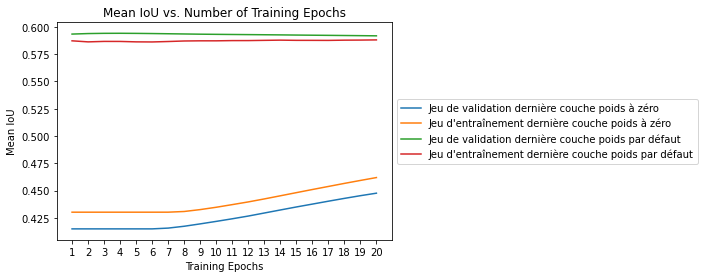

In [24]:
#inspiré de https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#comparison-with-model-trained-from-scratch
def show_training_per_epoch(list_to_show, num_epochs):

  plt.title("Mean IoU vs. Number of Training Epochs")
  plt.xlabel("Training Epochs")
  plt.ylabel("Mean IoU")

  min = 0.0
  max = 0.0
  for name, value in list_to_show.items():
    plt.plot(range(1,num_epochs+1),[h for h in value],label=name)
    min = np.min([h for h in value]) if (np.min([h for h in value])<min) or (min is 0.0) else min
    max = np.max([h for h in value]) if np.max([h for h in value])>max else max


  plt.ylim((min-0.01,max+0.01))
  plt.xticks(np.arange(1, num_epochs+1, 1.0))
  plt.legend(bbox_to_anchor=(1,0.5) , loc='center left')
  plt.show()

show_training_per_epoch({"Jeu de validation dernière couche poids à zéro":model_weight_init_at_zero_on_last_qualifier_layer_val_hist,
                         "Jeu d'entraînement dernière couche poids à zéro":model_weight_init_at_zero_on_last_qualifier_layer_train_hist,
                         "Jeu de validation dernière couche poids par défaut":model_only_one_parameter_loose_in_last_qualifier_layer_val_hist, 
                         "Jeu d'entraînement dernière couche poids par défaut":model_only_one_parameter_loose_in_last_qualifier_layer_train_hist},
                        num_epochs)

# Visualisation d'exemple par modèle

In [25]:
!rm -r /content/RCP209DeeplabExperiment
!rm -r /content/test_images

%cd /content
!git clone https://github.com/nyluje/RCP209DeeplabExperiment

!cp -r /content/RCP209DeeplabExperiment/test_images /content
!rm -r /content/RCP209DeeplabExperiment
!rm -r /content/test_images/readme.md

!pip install GPUtil

rm: cannot remove '/content/RCP209DeeplabExperiment': No such file or directory
/content
Cloning into 'RCP209DeeplabExperiment'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 62 (delta 28), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (62/62), done.


In [5]:
%ls /content/test_images -a -l

total 1284
drwxr-xr-x 2 root root   4096 Apr 16 08:53 ./
drwxr-xr-x 1 root root   4096 Apr 16 08:53 ../
-rw-r--r-- 1 root root 381425 Apr 16 08:53 img01.jpg
-rw-r--r-- 1 root root 456033 Apr 16 08:53 img02.jpg
-rw-r--r-- 1 root root 459523 Apr 16 08:53 img03.jpg


In [1]:

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
from torch.nn import parameter
from torch import cuda
from torch.utils.data import DataLoader, Subset
import torch.optim as optim


import torchvision
from torchvision.datasets import VOCSegmentation
from torchvision import transforms as T, models
#import torchsummary
#from torchsummary import summary

import os
import time
import datetime
import random
import sys


import GPUtil


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def get_pascal_labels():
    """Load the mapping that associates pascal classes with label colors
    Returns:
        np.ndarray with dimensions (21, 3)
    """
    return np.asarray(
        [
            [0, 0, 0],
            [128, 0, 0],
            [0, 128, 0],
            [128, 128, 0],
            [0, 0, 128],
            [128, 0, 128],
            [0, 128, 128],
            [128, 128, 128],
            [64, 0, 0],
            [192, 0, 0],
            [64, 128, 0],
            [192, 128, 0],
            [64, 0, 128],
            [192, 0, 128],
            [64, 128, 128],
            [192, 128, 128],
            [0, 64, 0],
            [128, 64, 0],
            [0, 192, 0],
            [128, 192, 0],
            [0, 64, 128],
        ]
    )

def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  print(np.ndim(label))
  if np.ndim(label) != 2:
#  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  #colormap = create_pascal_label_colormap()
  colormap = get_pascal_labels()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]

LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)


2


| ID | GPU | MEM |
------------------
|  0 |  0% | 35% |
at init None
device.max_memory_reserved 6977224704
mem_get_info (11013980160, 17071734784)
| ID | GPU | MEM |
------------------
|  0 |  0% | 35% |
start function None
img01
2


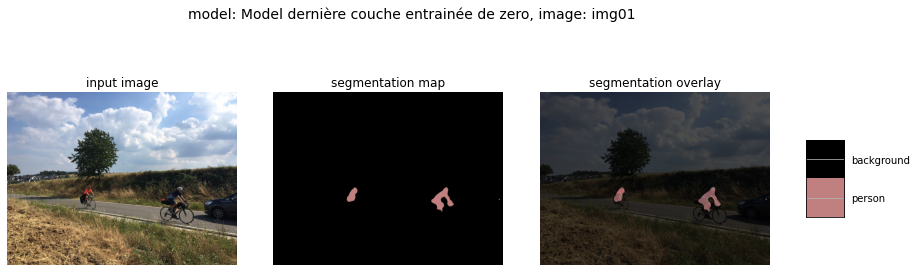

2


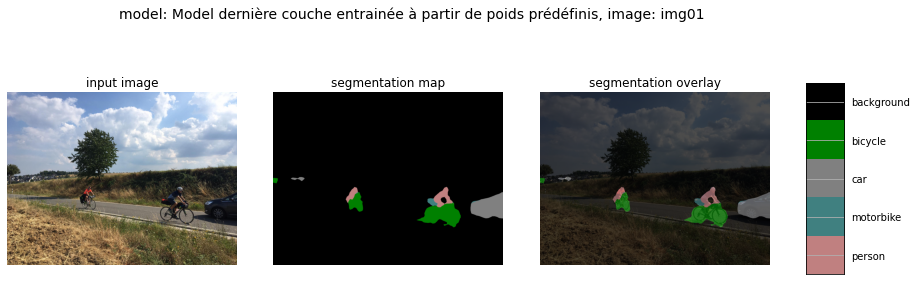

2


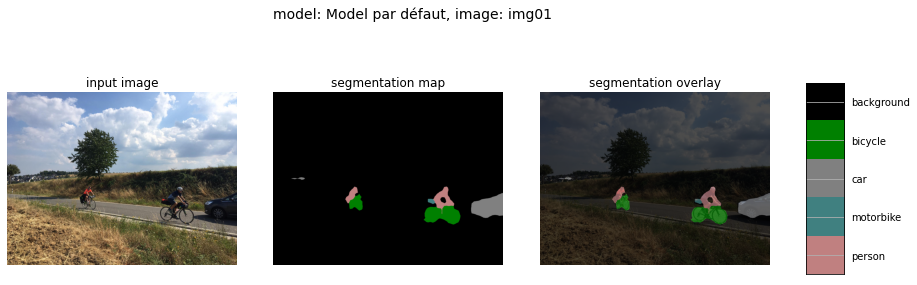

img02
2


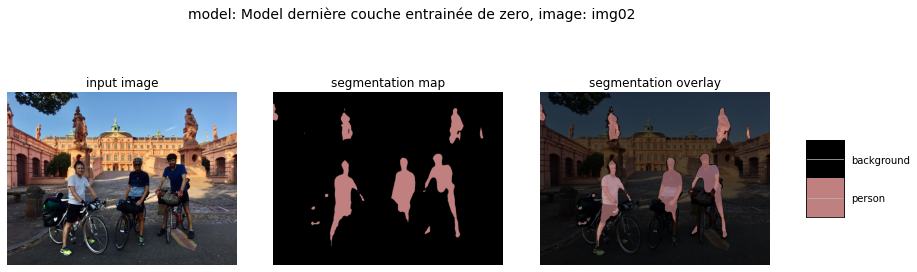

2


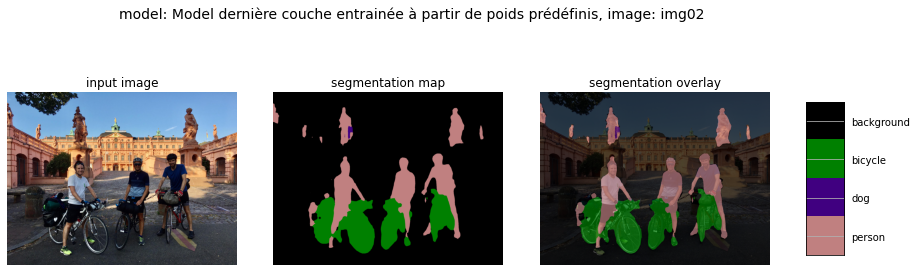

2


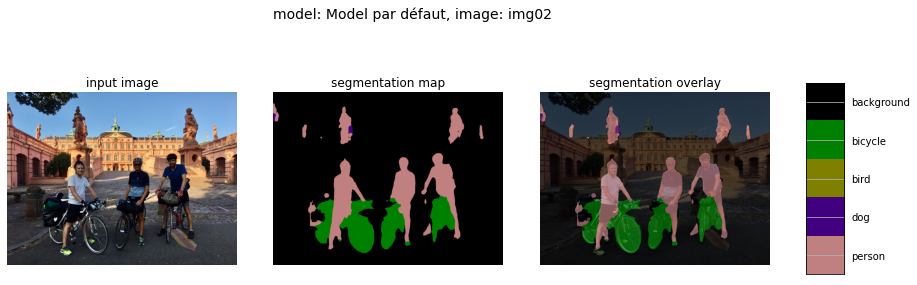

img03
2


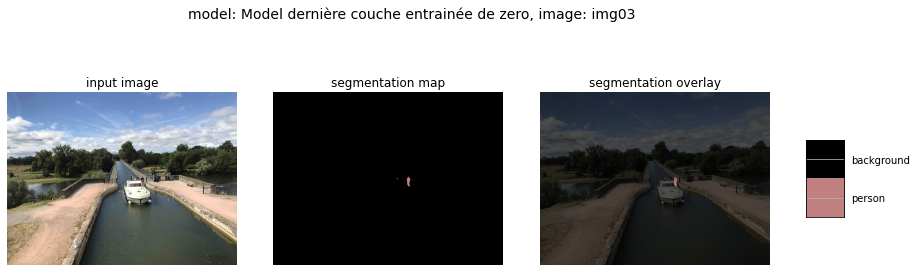

2


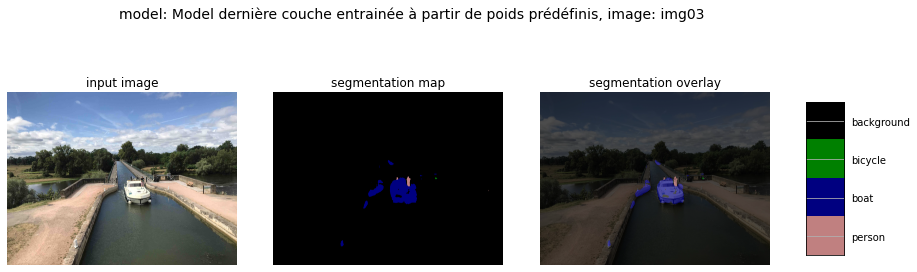

RuntimeError: ignored

In [35]:
from pathlib import Path
from matplotlib import gridspec
from torchvision.io import read_image
import gc



print(f"at init {GPUtil.showUtilization()}")
print(f"device.max_memory_reserved {torch.cuda.max_memory_reserved()}")
print(f"mem_get_info {torch.cuda.mem_get_info()}")
print(f"start function {GPUtil.showUtilization()}")

#inspiré de https://notebook.community/cshallue/models/research/deeplab/deeplab_demo
def show_demo(models_dict={"Model par défaut":models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True,progress=False)},dataset_dir_root="/content",specific_dataset_dir='test_images',image_root_name='img',image_idx=2, device=device):

  path_to_images = Path(os.path.join(dataset_dir_root,specific_dataset_dir))
  number_of_images=len(os.listdir(path_to_images))



  for i in range(0,number_of_images):


    padding_index= "0"*(image_idx-len(str(number_of_images)))
    image_id=image_root_name+padding_index+str(i+1)
    print(image_id)
    image_path = Path(os.path.join(path_to_images,image_id+'.jpg'))

    img = read_image(str(image_path))
    img_pil = T.functional.to_pil_image(read_image(str(image_path)))

    batch_img = torch.stack([img])
    
    batch = T.functional.convert_image_dtype(batch_img, dtype=torch.float)
    batch = T.functional.normalize(batch,mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
    batch = batch.to(device)

    for idx,model_to_use in models_dict.items():

      model_to_use.to(device).eval()

      output = model_to_use(batch)['out']
      #print(f"output shape {output.shape}")
      normalized_masks = torch.nn.functional.softmax(output, dim=1)
      #print(f"normalized_masks shape {normalized_masks.shape}")
      mask = normalized_masks.argmax(1)
      segmentation_layout = T.functional.to_pil_image(mask[0].int())

      del output
      del model_to_use
      gc.collect()
      torch.cuda.empty_cache()

      #plt.subplot(grid_spec[i][0])
      plt.figure(figsize=(15, 5))
      grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

      plt.suptitle(f"model: {idx}, image: {image_id}", size=14)
      
      plt.subplot(grid_spec[0])
      plt.imshow(img_pil)
      plt.axis('off')
      plt.title('input image')

      plt.subplot(grid_spec[1])
      seg_image = label_to_color_image(segmentation_layout).astype(np.uint8)
      plt.imshow(seg_image)
      plt.axis('off')
      plt.title('segmentation map')

      plt.subplot(grid_spec[2])
      plt.imshow(img_pil)
      plt.imshow(seg_image, alpha=0.7)
      plt.axis('off')
      plt.title('segmentation overlay')

      unique_labels = np.unique(segmentation_layout)
      unique_labels = np.delete(unique_labels, np.where(unique_labels == 255))
      ax = plt.subplot(grid_spec[3])
      plt.imshow(
          FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
      ax.yaxis.tick_right()
      plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
      plt.xticks([], [])
      ax.tick_params(width=0.0)
      plt.grid('off')
      plt.show()


    del batch
    gc.collect()
    torch.cuda.empty_cache()



show_demo({"Model dernière couche entrainée de zero": model_weight_init_at_zero_on_last_qualifier_layer, 
           "Model dernière couche entrainée à partir de poids prédéfinis": model_only_one_parameter_loose_in_last_qualifier_layer})






In [4]:

from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large
import torchvision.transforms.functional as F
from matplotlib import gridspec
from matplotlib import pyplot as plt
import os
from pathlib import Path
from torchvision.io import read_image
import torch.nn.functional

import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


#model = 
model = deeplabv3_mobilenet_v3_large(pretrained=True)
#model = model_weight_init_at_zero_on_all_qualifier_layers
#model = model_only_one_parameter_loose_in_qualifier_layers
model.to(device).eval()

dataset_dir_root="/content"
specific_dataset_dir='test_images'
#image_location= "VOC2012/JPEGImages"
#seg_location= "VOC2012/SegmentationClass"
#image_id = '2008_006903'
image_id = 'img03'

imagepath = Path(os.path.join(dataset_dir_root,specific_dataset_dir,image_id+'.jpg'))
#imagepath = Path(os.path.join(dataset_dir_root,specific_dataset_dir,image_location,image_id+'.jpg'))
#segpath = Path(os.path.join(dataset_dir_root,specific_dataset_dir,seg_location,image_id+'.png'))

testimg = read_image(str(imagepath))
testimgpil = F.to_pil_image(read_image(str(imagepath)))

#testseg = F.to_pil_image(read_image(str(segpath)))

batch_int = torch.stack([testimg])
batch = F.convert_image_dtype(batch_int, dtype=torch.float)
batch = F.normalize(batch,mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))

output = model(batch.to(device))['out']
print(f"output shape {output.shape}")
normalized_masks = torch.nn.functional.softmax(output, dim=1)
print(f"normalized_masks shape {normalized_masks.shape}")
mask = normalized_masks.argmax(1)
testseg = F.to_pil_image(mask[0].int())


print(torch.unique(mask))
#    image=F.to_pil_image(image)
#    axs[0,i].imshow(np.asarray(image))

def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  print(np.ndim(label))
  if np.ndim(label) != 2:
#  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]

def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  unique_labels = np.delete(unique_labels, np.where(unique_labels == 255))
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)


vis_segmentation(testimgpil,testseg)


RuntimeError: ignored

# TO DELETE

In [ ]:
def get_sgd_optimizer_with_model_params_to_update(model, learning_rate=0.001, momentum=0.9):
  #param_to_update = model.parameters()
  #feature_extract=True #si vrai mise à jour des coucher de la fin
  #if feature_extract:
  params_to_update=[]
  for name, param in model.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)
        #print("\t",name)
  #else:
    #for name,param in model.named_parameters():
      #if param.requires_grad==True:
        #print("\t",name)
  print(f"before params_to_update optimizer_ft.zero_grad() {params_to_update}")

  #utilisation de l'optimizer descente de gradient stochastique, 
  #lr: correspond au learning rate, ou taux d'apprentissage,
  # et momemtum est le facteur permettant de pondérer la dynamique de variation du gradient en tenant compte des valeurs précédente dans l'itération
  #optimizer_ft = optim.SGD(params_to_update,lr=0.001,momentum=0.9) #to check in other exampled what optimizer is used
  return  optim.SGD(params_to_update,lr=learning_rate,momentum=momentum) 



#met le modèle dans le GPU
#print(device)
#model_dl = model_dl.to(device)
#optimizer_ft = get_optimizer_with_model_params_to_update(model_dl)


In [ ]:


#fonction pour bloquer ou libérer le calcul de gradient d'un model ou d'une partie d'un model
#def set_parameters_requires_grad(model,req_grad):
def set_parameters_requires_grad(model,req_grad,set_to_zero_weight):
    for param in model.parameters():
      param.requires_grad = req_grad
    for name, param in model.named_parameters():
    #  #print(f'name {name} grad {param.requires_grad}')
    #  ####set param to 0
      if set_to_zero_weight is True:
        param.data.fill_(0.01)
    #  print(f'name {name}, param.data: {param.data}')


#fonction pour compter les paramètres bloqués ou non d'un model ou d'une partie d'un model
def display_count_grad_val_true_and_false_parameters(model):
  count_true=0
  count_false=0
  for param in model.parameters():
    if param.requires_grad is True:
      count_true+=1
    else:
      count_false+=1
  print(f'On model {model.__class__.__name__}, alterable gradient parameters number is {count_true},blocked gradient parameters number is: {count_false}')


#fonction pour bloquer les paramètres du modèle
#def block_parameters_in_layers(model,backbone_layers_to_set_loose=0,aux_classifier_layers_to_set_loose=0,classifier_layers_to_set_loose=0):
def block_parameters_in_layers(model,backbone_layers_to_set_loose=0,aux_classifier_layers_to_set_loose=0,classifier_layers_to_set_loose=0,set_to_zero_weight=False):
  block_parameters=True
  backbone_number_of_layers= model.backbone.__len__()
  aux_classifier_number_of_layers= model.aux_classifier.__len__() 
  classifier_number_of_layers= model.classifier.__len__() 
  #print(f"backbone_number_of_layers {backbone_number_of_layers}, aux_classifier_number_of_layers {aux_classifier_number_of_layers} , classifier_number_of_layers {classifier_number_of_layers}")

  if (backbone_layers_to_set_loose<=backbone_number_of_layers)&(aux_classifier_layers_to_set_loose<=aux_classifier_number_of_layers)&(classifier_layers_to_set_loose<=classifier_number_of_layers):
    set_parameters_requires_grad(model.backbone,False,False)
    set_parameters_requires_grad(model.aux_classifier,False,False)  
    set_parameters_requires_grad(model.classifier,False,False)  
#    set_parameters_requires_grad(model.backbone,False)
#    set_parameters_requires_grad(model.aux_classifier,False)  
#    set_parameters_requires_grad(model.classifier,False)



    #Selection au hasard des couches sur lesquels les paramètres de gradient seront débloqués pour mise à jour possible
    layers_to_set_loose_on_backbone = np.random.choice(np.arange(backbone_number_of_layers), backbone_layers_to_set_loose, replace=False)
    layers_to_set_loose_on_classifier = np.random.choice(np.arange(classifier_number_of_layers), classifier_layers_to_set_loose, replace=False)
    layers_to_set_loose_on_aux_classifier = np.random.choice(np.arange(aux_classifier_number_of_layers), aux_classifier_layers_to_set_loose, replace=False)
    #print(f'layers_to_set_loose_on_backbone {layers_to_set_loose_on_backbone}')
    #print(f'layers_to_set_loose_on_classifier {layers_to_set_loose_on_classifier}')
    #print(f'layers_to_set_loose_on_aux_classifier {layers_to_set_loose_on_aux_classifier}')
    for ltslob in layers_to_set_loose_on_backbone: set_parameters_requires_grad(model.backbone[str(ltslob)],True, set_to_zero_weight)
    for ltsloc in layers_to_set_loose_on_classifier: set_parameters_requires_grad(model.classifier[ltsloc],True,  set_to_zero_weight)
    for ltsloac in layers_to_set_loose_on_aux_classifier: set_parameters_requires_grad(model.aux_classifier[ltsloac],True,set_to_zero_weight)  
#    for ltslob in layers_to_set_loose_on_backbone: set_parameters_requires_grad(model.backbone[str(ltslob)],True)
#    for ltsloc in layers_to_set_loose_on_classifier: set_parameters_requires_grad(model.classifier[ltsloc],True)
#    for ltsloac in layers_to_set_loose_on_aux_classifier: set_parameters_requires_grad(model.aux_classifier[ltsloac],True)  



    #set_to_zero_weight=set_to_zero_weight
    #for layer_num in range(model.classifier.__len__()):
    #  print(f'layer {layer_num}, val:{model.classifier[layer_num]}')
    #  for name, param in model.classifier[layer_num].named_parameters():
    #    print(f'name {name} grad {param.requires_grad}')
    #    ####set param to 0
    #    if set_to_zero_weight is True:
    #      param.data.fill_(0.01)
  else:
    raise Exception(f"Number of layers required to set loose is more than availabe in one of the 3 main layers, backbone_layers_to_set_loose: {backbone_layers_to_set_loose} , backbone_number_of_layers: {backbone_number_of_layers} ; aux_classifier_to_set_loose: {aux_classifier_to_set_loose} , aux_classifier_number_of_layers: {aux_classifier_number_of_layers} ; classifier_layers_to_set_loose: {classifier_layers_to_set_loose} , classifier_number_of_layers: {classifier_number_of_layers}")


display_count_grad_val_true_and_false_parameters(model_dl.backbone)
display_count_grad_val_true_and_false_parameters(model_dl.classifier)
display_count_grad_val_true_and_false_parameters(model_dl.aux_classifier)

#block_parameters=True
#if block_parameters is True:
#  print(model_dl.classifier[model_dl.classifier.__len__()-1])
#  set_parameters_requires_grad(model_dl.backbone,True)
#  set_parameters_requires_grad(model_dl.aux_classifier,True)
#  print(model_dl.classifier[model_dl.classifier.__len__()-1].in_channels)
#  #set_parameters_requires_grad(model_dl.classifier[0],True)
#  for ind in range(0,model_dl.classifier.__len__()-1):
#    set_parameters_requires_grad(model_dl.classifier[ind],True)


#set_to_zero_weight=False
#for layer_num in range(model_dl.classifier.__len__()):
#  print(f'layer {layer_num}, val:{model_dl.classifier[layer_num]}')
#  for name, param in model_dl.classifier[layer_num].named_parameters():
#    print(f'name {name} grad {param.requires_grad}')
#    ####set param to 0
#    if set_to_zero_weight is True:
#      param.data.fill_(0.01)



block_parameters_in_layers(model_dl,backbone_layers_to_set_loose=1,aux_classifier_layers_to_set_loose=0,classifier_layers_to_set_loose=1,set_to_zero_weight=False)
#block_parameters_in_layers(model_dl,backbone_layers_to_set_loose=1,aux_classifier_layers_to_set_loose=0,classifier_layers_to_set_loose=1)


display_count_grad_val_true_and_false_parameters(model_dl.backbone)
display_count_grad_val_true_and_false_parameters(model_dl.classifier)
display_count_grad_val_true_and_false_parameters(model_dl.aux_classifier)


In [ ]:
#from scikit-learn.metrics import jaccard_similarity_score as jsc
#import sklearn.metrics as metrics
"""
def test_model(model, dataloaders):
  model.eval()
  intersection_total=0
  union_total=0

  confmat = ConfusionMatrix(21)

  for input, target in dataloaders['val']:
    input= input.to(device) 
    target = target.to(device)
    output = model(input)['out']
    target=target.squeeze(1) #https://discuss.pytorch.org/t/semantic-segmentation-loss-function/48431/3

    normalized_masks_batch = torch.nn.functional.softmax(output,dim=1)
    classtocheck_batch=torch.unique(target[0])
    classtocheck_batch = classtocheck_batch[1:classtocheck_batch.__len__()-1]

    norm_masks_batch_pic = [
      normalized_masks_batch[0,int(cls)]
      for cls in classtocheck_batch
    ]
    #showImage(norm_masks_batch_pic)



    for indexinpvstar in range(0,input.__len__()):
      
      #showImage([input[indexinpvstar]])

      classtocheck=torch.unique(target[indexinpvstar])
      classtocheck = classtocheck[1:classtocheck.__len__()-1]
      print(f"class to check on image  {classtocheck}")

      normalized_masks = torch.nn.functional.softmax(output[indexinpvstar], dim=0)
      #norm_mask_pic = [normalized_masks[int(cls)]
      #                for cls in classtocheck
      #                 ]
      #showImage(norm_mask_pic)

      class_masks=  [normalized_masks.argmax(0)==int(cltoc) for cltoc in classtocheck]
      print(f"zesklmjrzejklmrezjklrzejklzerjkl {class_masks.__len__()} {normalized_masks.shape} , argmax shape {normalized_masks.argmax(0).shape} uni {torch.unique(normalized_masks.argmax(0))}")

      #showImage([m.float() for m in class_masks])



      for cltoc in classtocheck:
        class_dim=0
        class_masks= (normalized_masks.argmax(class_dim)==int(cltoc))
        target_masks= (target[indexinpvstar]==int(cltoc))
        #print(f"cltoc is {int(cltoc)}; class_masks.shape {class_masks.shape} , {torch.unique(class_masks)} , target.shape {target_masks.shape}  {torch.unique(target_masks)}")
        intersection = torch.logical_and(class_masks.flatten(),target_masks.flatten())
        union = torch.logical_or(class_masks.flatten(),target_masks.flatten())
        intersection_total+=torch.sum(intersection==True)
        union_total+=torch.sum(union==True)
        #print(f"union {union.shape} true sum {torch.sum(union == True)}")
        #print(f"intersec {intersection.shape} true sum {torch.sum(intersection == True)}")
        iou = torch.sum(intersection==True)/torch.sum(union==True)
        print(f'iou is {iou}')

      img_background_mask = (normalized_masks.argmax(0)==0) #les éléments du background
      target_background_mask =  (target[indexinpvstar]==0)
      intersection_background = torch.logical_and(img_background_mask.flatten(),target_background_mask.flatten())
      union_background = torch.logical_or(img_background_mask.flatten(),target_background_mask.flatten())
      intersection_total+=torch.sum(intersection_background==True)
      union_total+=torch.sum(union_background==True)

    confmat.intersection_over_union(output, target)

  print(f"intersection_total {intersection_total} , union_total {union_total}, ratio {intersection_total/union_total}")
  print(f"confmat {confmat.get_global_ratio()}")
  print(f"confmat ratio per class {confmat.get_ratio_per_class()}")
  #print(f"confmat.matrix_total_intersection_over_union {confmat.matrix_total_intersection_over_union}")


model_dl_for_test=models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True,progress=False)
model_dl_for_test.to(device)
test_model(model_dl_for_test,dataloaders_dict)
"""



In [18]:
from torchvision.models.segmentation.deeplabv3 import DeepLabV3
#print(dlv3mnv3l)
#https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

#import utils

import time
import copy
#la fonction train model gere l'entrainement et la validation d'un modele donné. Il prend en entrée:
# - un model PyTorch
# - un dictionnaire de données chargées
# - une fonction de perte
# - un optimizer
# - un nombre défini de tour d'entrainement et validation (epoch)
# - et un flag boolean pour les modèles d'inception (inception_v3)
def train_model(model, dataloaders, lossfunction, optimizer, num_epochs=10,is_inception=False):
  since = time.time()
  #val_acc_history = []
  val_mean_iou_history = []
  best_model_wts = copy.deepcopy(model.state_dict())
  #best_acc=0.0
  best_mean_iou = 0.0

  #try conf mat
  num_class=model.classifier[model_dl.classifier.__len__()-1].out_channels #récupération du nombre de classe à partir de l'ouput channels du classifieur
  confmat={x: ConfusionMatrix(num_class) for x in ['train','val']}


  for epoch in range(num_epochs):
    print(f"Epoch {epoch}/{num_epochs-1}")
    #print('-'*10)

    #chaque epoch a une phase d'entrainement et de validation
    for phase in ['train','val']:
    #for phase in ['train']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      running_loss =0.0
      running_corrects=0


      #Itération sur les données
      for input, target in dataloaders[phase]:
#      for inputs, labels in dataloaders[phase]:
        print(f"loop test {input.shape} , targer.shape {target.shape} , torh unique target {torch.unique(target)}")
        input= input.to(device) 
        target = target.to(device)

        target=target.squeeze(1) #https://discuss.pytorch.org/t/semantic-segmentation-loss-function/48431/3

        #zero the parameter gradients
        optimizer.zero_grad()

        #forward
        #track history if only in train
        with torch.set_grad_enabled(phase=='train'):
          #récupération du model en sortie et calcul de la perte
          #cas spécial pour l'inception car en entrainement il y a une sortie auxiliaire. En entrainement, la perte est calculée 
          #sur la sortie finale et les sorties auxiliaires
          #mais en sortie seulement la sortie finale est considérée
          if is_inception and phase == 'train':
            output, aux_output = model(input)['out']
            loss1 = lossfunction(output, target)
            loss2 = lossfunction(aux_output, target)
            loss = loss1 + 0.4*loss2
          else:
            output = model(input)['out']
            # print(f"output shape affter out {output.shape} , output.shape {output[0].shape}")

            #normalized_masks = torch.nn.functional.softmax(output[0], dim=1)
            #for nmi in normalized_masks:
              #print(f"normalized_masks i  {nmi.shape}")
                           

            print(f'output.shape {output.shape}, target.shape {target.shape}')
            loss = lossfunction(output, target.long()) 
            print(f"loss {loss}")


          #_, preds = torch.max(output,1)
          confmat[phase].intersection_over_union(output,target)
              
          #optimisation seulement en phase d'entrainement
          if phase == 'train':
            loss.backward()
            optimizer.step()
          running_loss += loss.item() * input.size(0)
          #running_corrects += torch.sum(preds == target.data)
          #running_corrects += torch.sum(input = target)

          #torch.set_printoptions(profile="full")
          #print(f"preds 1st { _.shape } , preds {preds.shape}")
          #print(f"preds _ unique { torch.unique(_) } , preds unique { torch.unique(preds)}")
          #print(f"target data = {target.data[0]}")
          #print(f"running correcst = {running_corrects}")
          #torch.set_printoptions(profile="default") # reset




        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        #epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        epoch_mean_iou = confmat[phase].get_global_ratio()[0]

        #print(f"{phase} loss= {epoch_loss:.4f} acc = {epoch_acc:.4f} mean_iou = {epoch_mean_iou:.4f} ")
        print(f"{phase} loss= {epoch_loss:.4f}  mean_iou = {epoch_mean_iou:.4f} ")

        #conserver le modèle qui a donné les meilleures performances
        if phase == "val" and epoch_mean_iou > best_mean_iou:
        #if phase == "val" and epoch_acc > best_acc:
          #best_acc = epoch_acc
          best_mean_iou = epoch_mean_iou
          best_model_wts = copy.deepcopy(model.state_dict())
        if phase == 'val':
          #val_acc_history.append(epoch_acc)
          val_mean_iou_history.append(epoch_mean_iou)

  time_elapsed = time.time() - since
  print(f"training complete in {time_elapsed//60:.0f}m{time_elapsed % 60}")
  #print(f"Best val acc= {best_acc:4f}")
  print(f"best_mean_iou= {best_mean_iou:4f}")

  #chargement des meilleurs poids du model
  model.load_state_dict(best_model_wts)
    


#  return model, val_acc_history
  return model, val_mean_iou_history    



Epoch 0/9
loop test torch.Size([4, 3, 500, 500]) , targer.shape torch.Size([4, 1, 500, 500]) , torh unique target tensor([  0,   6,   9,  12,  15,  18, 255], dtype=torch.uint8)
output.shape torch.Size([4, 21, 500, 500]), target.shape torch.Size([4, 500, 500])
loss 2.216721534729004
train loss= 0.8867  mean_iou = 0.4125 
loop test torch.Size([4, 3, 500, 500]) , targer.shape torch.Size([4, 1, 500, 500]) , torh unique target tensor([  0,   2,   5,   9,  14,  15,  16,  20, 255], dtype=torch.uint8)
output.shape torch.Size([4, 21, 500, 500]), target.shape torch.Size([4, 500, 500])
loss 0.3438310921192169
train loss= 1.0242  mean_iou = 0.4399 
loop test torch.Size([2, 3, 500, 500]) , targer.shape torch.Size([2, 1, 500, 500]) , torh unique target tensor([  0,   6,   7,  10, 255], dtype=torch.uint8)
output.shape torch.Size([2, 21, 500, 500]), target.shape torch.Size([2, 500, 500])
loss 0.5993202924728394
train loss= 1.1441  mean_iou = 0.4660 
loop test torch.Size([4, 3, 500, 500]) , targer.shap

output shape torch.Size([1, 21, 1200, 1600])
normalized_masks shape torch.Size([1, 21, 1200, 1600])
tensor([ 0,  1,  2,  7, 14, 15])
2
2


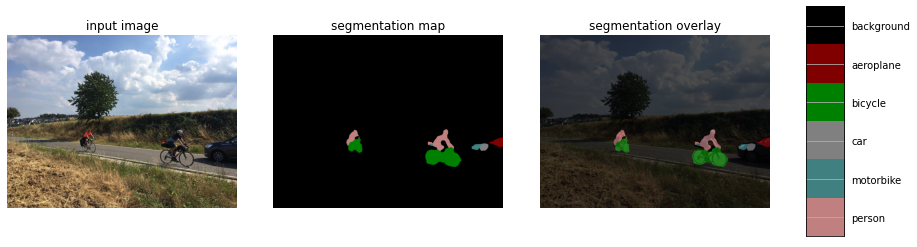

In [28]:

from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large
import torchvision.transforms.functional as F
from matplotlib import gridspec
from matplotlib import pyplot as plt
import os
from pathlib import Path
from torchvision.io import read_image
import torch.nn.functional

model = deeplabv3_mobilenet_v3_large(pretrained=True,progress=False)
model.eval()

dataset_dir_root="/content"
specific_dataset_dir='test_images'
#image_location= "VOC2012/JPEGImages"
#seg_location= "VOC2012/SegmentationClass"
#image_id = '2008_006903'
image_id = 'img01'

imagepath = Path(os.path.join(dataset_dir_root,specific_dataset_dir,image_id+'.jpg'))
#imagepath = Path(os.path.join(dataset_dir_root,specific_dataset_dir,image_location,image_id+'.jpg'))
#segpath = Path(os.path.join(dataset_dir_root,specific_dataset_dir,seg_location,image_id+'.png'))

testimg = read_image(str(imagepath))
#testimgnorm = F.normalize(testimgpil, mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))

testimgpil = F.to_pil_image(read_image(str(imagepath)))

#testseg = F.to_pil_image(read_image(str(segpath)))

batch_int = torch.stack([testimg])
batch = F.convert_image_dtype(batch_int, dtype=torch.float)


output = model(batch)['out']
print(f"output shape {output.shape}")
normalized_masks = torch.nn.functional.softmax(output, dim=1)
print(f"normalized_masks shape {normalized_masks.shape}")
mask = normalized_masks.argmax(1)
testseg = F.to_pil_image(mask[0].int())


print(torch.unique(mask))
#    image=F.to_pil_image(image)
#    axs[0,i].imshow(np.asarray(image))

def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  print(np.ndim(label))
  if np.ndim(label) != 2:
#  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  unique_labels = np.delete(unique_labels, np.where(unique_labels == 255))
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

vis_segmentation(testimgpil,testseg)


torch.Size([1, 21, 375, 500])


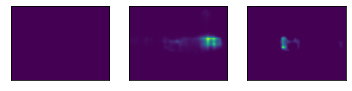

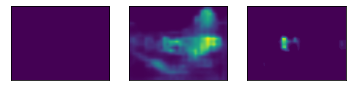

In [ ]:
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
from torchvision.transforms.functional import convert_image_dtype


model_dl.eval()
image_location= "VOC2012/JPEGImages"
imagepath = Path(os.path.join(dataset_dir_root,specific_dataset_dir,image_location))

testimg = read_image(str(imagepath/'2008_006903.jpg'))
#grid = make_grid([testimg,testimg])
#showImage(grid)


#vocSegDatasetTesting= VOCSegmentation(root=dataset_dir_root,image_set="val",year='2012'
#                                ,download=vocDevkitNeedToBeDownloaded
#                                )
#dataloaders_dict.update(num_workers=0)
#dataloadersTesting = DataLoader(vocSegDatasetTesting,batch_size=1,shuffle=False,num_workers=1)

#for input, target in dataloadersTesting:
#  input.to(device)
#dataloadersTesting[0].to(device)
#print(vocSegDatasetTesting.__len__())

#print(vocSegDatasetTesting[0])

#testimg= vocSegDatasetTesting[0].to(device)

batch_int = torch.stack([testimg])
batch = convert_image_dtype(batch_int, dtype=torch.float)

model_dl.to('cpu')

output = model_dl(batch)['out']


sem_classes = ['__background__','airplane','bike','bird','boat','bottle','bus','car','cat','chair','cow','table','dog','horse','motobike','human','pottedplant','sheep','sofa','train','tv']
sem_class_to_idx ={cls: idx for (idx,cls) in enumerate(sem_classes)}
normalized_masks = torch.nn.functional.softmax(output, dim=1)
print(normalized_masks.shape) #nombre d'image dans le batch
#print(normalized_masks) #nombre d'image dans le batch

dog_and_boat_masks = [
  normalized_masks[img_idx,sem_class_to_idx[cls]]
  for img_idx in range(batch.shape[0])
  for cls in ('dog','boat','human')
]
showImage(dog_and_boat_masks)

model_not_changed = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True,progress=False)
model_not_changed.eval()
output_not_changed = model_not_changed(batch)['out']
normalized_masks_not_changed = torch.nn.functional.softmax(output_not_changed, dim=1)
dog_and_boat_masks_not_changed = [
  normalized_masks_not_changed[img_idx,sem_class_to_idx[cls]]
  for img_idx in range(batch.shape[0])
  for cls in ('dog','boat','human')
]
showImage(dog_and_boat_masks_not_changed)


In [ ]:
#https://pytorch.org/vision/0.12/auto_examples/plot_visualization_utils.html#semantic-seg-output

#utlitaire de visualisation
import torchvision.transforms.functional as F


#plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["savefig.bbox"] = 'standard'


def showImage(images):
  if not isinstance(images,list): #controle qu'une liste soit bien passée, si c'est une image unique elle est insérér dans un tableau
    images=[images]
  fix, axs = plt.subplots(ncols=len(images),squeeze=False)
  for i, image in enumerate(images):
    #print(i)
    #print(dir(image))
    image=image.detach()
    image=F.to_pil_image(image)
    axs[0,i].imshow(np.asarray(image))
    axs[0,i].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])


def showImageReady(images):
  if not isinstance(images,list): #controle qu'une liste soit bien passée, si c'est une image unique elle est insérér dans un tableau
    images=[images]
  fix, axs = plt.subplots(ncols=len(images),squeeze=False)
  for i, image in enumerate(images):
    #print(i)
    #print(dir(image))
#    image=image.detach()
#    image=F.to_pil_image(image)
    axs[0,i].imshow(np.asarray(image))
    axs[0,i].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])



#get data and train the last layer of the model
#normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            #     std=[0.229, 0.224, 0.225])




In [ ]:
test = [
        {"params": [p for p in model_dl.backbone.parameters() if p.requires_grad]},
        {"params": [p for p in model_dl.classifier.parameters() if p.requires_grad]},
    ]
print(test[1]["params"].__len__())
#for x in range(0,test.__len__()):
#  print(test[x])

#print('toto')


5


In [ ]:
#from torchvision.models.segmentation.deeplabv3 import 
from torchvision import models

for i in dir(models): print(i)


AlexNet
DenseNet
EfficientNet
GoogLeNet
GoogLeNetOutputs
Inception3
InceptionOutputs
MNASNet
MobileNetV2
MobileNetV3
RegNet
ResNet
ShuffleNetV2
SqueezeNet
VGG
_GoogLeNetOutputs
_InceptionOutputs
__builtins__
__cached__
__doc__
__file__
__loader__
__name__
__package__
__path__
__spec__
_utils
alexnet
densenet
densenet121
densenet161
densenet169
densenet201
detection
efficientnet
efficientnet_b0
efficientnet_b1
efficientnet_b2
efficientnet_b3
efficientnet_b4
efficientnet_b5
efficientnet_b6
efficientnet_b7
feature_extraction
googlenet
inception
inception_v3
mnasnet
mnasnet0_5
mnasnet0_75
mnasnet1_0
mnasnet1_3
mobilenet
mobilenet_v2
mobilenet_v3_large
mobilenet_v3_small
mobilenetv2
mobilenetv3
quantization
regnet
regnet_x_16gf
regnet_x_1_6gf
regnet_x_32gf
regnet_x_3_2gf
regnet_x_400mf
regnet_x_800mf
regnet_x_8gf
regnet_y_16gf
regnet_y_1_6gf
regnet_y_32gf
regnet_y_3_2gf
regnet_y_400mf
regnet_y_800mf
regnet_y_8gf
resnet
resnet101
resnet152
resnet18
resnet34
resnet50
resnext101_32x8d
resnext5

In [ ]:
!pip install torchsummary

Pour commencer un model précontruit est sélectionné parmi le package `torchvision.models`. Le modèle DeepLab v3 construit sur le mobilenet est sélectionné `deeplabv3_mobilenet_v3_large(pretrained=True,progress=False)` , le paramètre `pretrained` permet d'utiliser des poids déjà entrainés, le paramètre `progress`permet de spécifié si l'utilisateur souhaite voir la barre de progrès lors du chargement du modèle.

In [ ]:
!ls /content/drive/MyDrive/RCP209/datasets/pascal_voc_seg/VOC2012/JPEGImages/2008_006902.jpg

ls: cannot access '/content/drive/MyDrive/RCP209/datasets/pascal_voc_seg/VOC2012/JPEGImages/2008_006902.jpg': No such file or directory


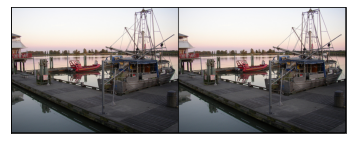

In [ ]:
#visualisation d'une grille d'images
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path


image_location= "VOC2012/JPEGImages"
imagepath = Path(os.path.join(dataset_dir_root,specific_dataset_dir,image_location))

testimg = read_image(str(imagepath/'2008_006903.jpg'))
grid = make_grid([testimg,testimg])
showImage(grid)

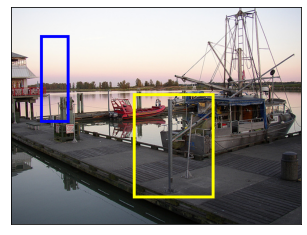

In [ ]:
#bounding boxes
from torchvision.utils import draw_bounding_boxes
boxes = torch.tensor([[50,50,100,200],[210,150,350,330]],dtype=torch.float)
colors=['blue','yellow']
result = draw_bounding_boxes(testimg,boxes,colors=colors,width=5)
showImage(result)

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms.functional import convert_image_dtype
batch_int = torch.stack([testimg])
batch = convert_image_dtype(batch_int, dtype=torch.float)

model = fasterrcnn_resnet50_fpn(pretrained=True,progress=False)
evaluationProvidedByModel = model.eval()

outputs = evaluationProvidedByModel(batch)
print(outputs)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[{'boxes': tensor([[ 25.6714, 196.7924,  52.8190, 214.1130],
        [171.4736, 156.0438, 266.5989, 194.4975],
        [275.4010, 144.4845, 340.5992, 179.2980],
        [246.5744,   3.3199, 488.0864, 263.3842],
        [192.7298, 139.3143, 472.5115, 279.3448],
        [275.9847, 140.9954, 414.2402, 184.5185],
        [171.1855, 159.8381, 212.5408, 189.4283],
        [269.8184, 141.2919, 480.2721, 226.6021],
        [430.3775,  98.6996, 491.5742, 228.6742],
        [251.3534, 159.3800, 259.0671, 174.7318],
        [  0.6948, 152.7788, 483.6465, 341.8044],
        [276.4509, 145.7898, 340.6919, 175.7650],
        [160.4514, 156.3094, 275.5633, 238.3539],
        [ 43.1193, 191.9486,  62.7974, 201.3487],
        [186.7081, 174.9393, 265.6221, 196.0210],
        [264.8405, 172.1904, 470.5372, 265.5232],
        [167.9534, 182.4112, 185.3697, 192.4759],
        [441.8027, 172.1865, 490.4497, 226.1332],
        [188.5546, 169.6265, 266.9994, 188.2016],
        [289.3830,   2.3952, 484.2341, 

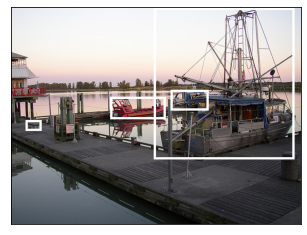

In [ ]:
score_threshold = .8
test_boxes = [draw_bounding_boxes(img_from_batch, boxes=output['boxes'][output['scores']>score_threshold],width=4) for img_from_batch, output in zip(batch_int,outputs)]
showImage(test_boxes)

torch.Size([1, 21, 375, 500]) -6.063499450683594 17.853593826293945
torch.Size([1, 21, 375, 500]) -5.69189977645874 15.871674537658691


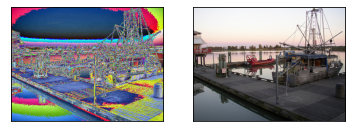

In [ ]:
#masque de segmentation

from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

model = deeplabv3_mobilenet_v3_large(pretrained=True,progress=False)
segmentationEval = model.eval()

batch_normalisation = F.normalize(batch, mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
output = model(batch_normalisation)['out']
outputNotNormalized = model(batch)['out']
print(outputNotNormalized.shape,outputNotNormalized.min().item(),outputNotNormalized.max().item())
print(output.shape,output.min().item(),output.max().item())
#La sortie de la segmentation par le modèle est un tenseur contenant la taille du batch, le nombre de classes, la hauteur et largeur. 
#Les valeurs ne sont pas un score normalisé, il peut être normalisé entre [0,1] en utilisant une fonction softmax. 
#Après la softmax, chaque valeur peut être interprété  comme une probabilité d'un pixel d'appartenir à une classe donnée

#print(batch_normalisation)
#print(batch)
from torchvision.transforms import ToPILImage
backNorm=ToPILImage()(batch_normalisation[0])
backNotNorm=ToPILImage()(batch[0])
showImageReady([backNorm,backNotNorm])
#fix, axs = plt.subplots(ncols=1,squeeze=False)
#axs[0,0].imshow(np.asarray(back))
#axs[0,0].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])


#fix, axs = plt.subplots(ncols=1,squeeze=False)
#axs[0,0].imshow(np.asarray(backNotNorm))
#axs[0,0].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])



output.shape torch.Size([1, 21, 375, 500]) , normalized_masks.shape torch.Size([1, 21, 375, 500])


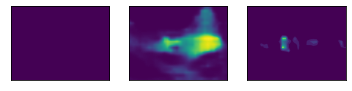

In [ ]:
#mask détecté pour classe bateau et chien
sem_classes = ['__background__','airplane','bike','bird','boat','bottle','bus','car','cat','chair','cow','table','dog','horse','motobike','human','pottedplant','sheep','sofa','train','tv']
sem_class_to_idx ={cls: idx for (idx,cls) in enumerate(sem_classes)}
#print(sem_class_to_idx['boat'])
#print(batch.shape[0]) #nombre d'image dans le batch
normalized_masks = torch.nn.functional.softmax(output, dim=1)
print(f"output.shape {output.shape} , normalized_masks.shape {normalized_masks.shape}") #nombre d'image dans le batch
#print(normalized_masks) #nombre d'image dans le batch

dog_and_boat_masks = [
  normalized_masks[img_idx,sem_class_to_idx[cls]]
  for img_idx in range(batch.shape[0])
  for cls in ('dog','boat','human')
]
showImage(dog_and_boat_masks)


tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
shape = torch.Size([1, 375, 500]), dtype =torch.bool , unique tensor([False,  True]), norm mask argmax unique tensor([0, 4])


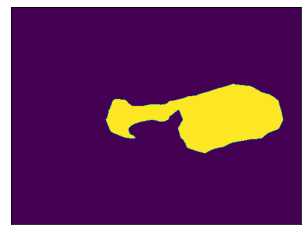

In [ ]:
class_dim=1
boolean_boat_masks= (normalized_masks.argmax(class_dim)==sem_class_to_idx['boat'])
print(boolean_boat_masks)
print(f"shape = {boolean_boat_masks.shape}, dtype ={boolean_boat_masks.dtype} , unique {torch.unique(boolean_boat_masks)}, norm mask argmax unique {torch.unique(normalized_masks.argmax(class_dim))}")
showImage([m.float() for m in boolean_boat_masks])

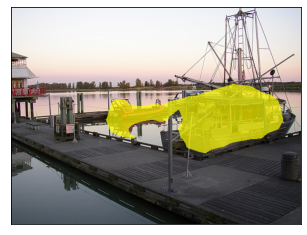

In [ ]:
from torchvision.utils import draw_segmentation_masks
boat_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=0.7,colors='yellow')
    for img, mask in zip(batch_int, boolean_boat_masks)
]
showImage(boat_with_masks)

#autres example https://pytorch.org/vision/0.12/auto_examples/plot_visualization_utils.html#semantic-seg-output

torch.Size([1, 21, 375, 500])
boat1_masks_shape = torch.Size([21, 375, 500]),dtype=torch.float32
boat1_all_classes_masks = torch.Size([21, 375, 500]),dtype=torch.bool


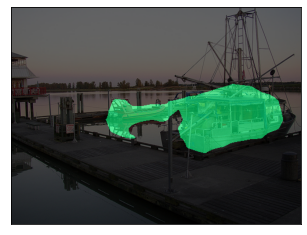

In [ ]:
print(normalized_masks.shape)
num_classes=normalized_masks.shape[1]
boat1_masks=normalized_masks[0]
class_dim=0
#torch.set_printoptions(profile="full")
#print(boat1_masks.argmax(class_dim))
#torch.set_printoptions(profile="default")
#torch.set_printoptions(precision=1)
#print(boat1_masks[4])

#print(torch.arange(num_classes)[:,None,None])
boat1_all_classes_masks=boat1_masks.argmax(class_dim)==torch.arange(num_classes)[:,None,None]
print(f"boat1_masks_shape = {boat1_masks.shape},dtype={boat1_masks.dtype}")
print(f"boat1_all_classes_masks = {boat1_all_classes_masks.shape},dtype={boat1_all_classes_masks.dtype}")

boat_with_all_masks = draw_segmentation_masks(testimg,masks=boat1_all_classes_masks, alpha=.6)
showImage(boat_with_all_masks)

In [ ]:
#exemple pour comprender boat1_masks.argmax(class_dim) ->cela renvoie l'argument max par rapport sur une des dimensions du tenseur (https://deeplizard.com/learn/video/K3lX3Cltt4c)

t = torch.tensor([
    [1,0,0,2],
    [0,3,3,0],
    [4,0,0,5]
], dtype=torch.float32)
#print(t.max())
#print(t.argmax())
#print(t.flatten())
#print(t.max(0))
print(t.argmax(0))
#print(t.flatten(0))


Entrainement du model

In [ ]:
!ls /content/drive/MyDrive/RCP209/datasets/pascal_voc_seg/VOC2012

ls: cannot access '/content/drive/MyDrive/RCP209/datasets/pascal_voc_seg/VOC2012': No such file or directory


In [ ]:
CustomDataset(csv_file='')

In [ ]:
!git clone https://github.com/msminhas93/DeepLabv3FineTuning

In [ ]:
%cd DeepLabv3FineTuning
!pip install -r requirements.txt


In [ ]:
!python main.py --data-directory CrackForest --exp_directory CFExp


In [ ]:
#https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html
#https://github.com/meetps/pytorch-semseg/blob/master/ptsemseg/loader/pascal_voc_loader.py


from pandas._libs.tslibs.conversion import localize_pydatetime
from numpy.ma.core import logical_and
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import os
import numpy as np
#from skimage import io, transform
import collections
from PIL import Image
from torchvision import transforms

class pascalVOCDataset(Dataset):
  """
    5 splits sont fournis pour travailler avec VOC data
    train: voc 2012 train data 1464 images
    val: voc 2012 validation data 1449 images
    trainval: train+val 2913 images
    train_aug: 8829 images
    train_aug_val: voc2012 validation data moins image de train_aug
  """
  def __init__(self, root_dir, sbd_path=None,split='train_aug', is_transform=False, img_size=512, 
               augmentations=None, img_norm=True,test_mode=False):
    """
    Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.root_dir= root_dir
    self.sbd_path = sbd_path
    self.is_transform = is_transform
    self.augmentations = augmentations
    self.img_norm= img_norm
    self.test_mode = test_mode
    self.n_classes = 21
    self.mean=np.array([104.00699, 116.66877, 122.67892])
    self.files=collections.defaultdict(list)
    self.img_size= img_size if isinstance(img_size,tuple) else (img_size,img_size)

    if not self.test_mode:
      for split in ["train", "val", "trainval"]:
        path=os.path.join(self.root_dir, "ImageSets/Segmentation", split+".txt")
        file_list=tuple(open(path,"r"))
        file_list = [id_.rstrip() for id_ in file_list]
        self.files[split]=file_list
      self.setup_annotations()

    self.tf = transform.Compose(
      [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ]  
    )


  def __len__(self):
    return len(self.files[self.split])

  def __getitem__(self,idx):
    im_name=self.files[self.split][index]
    im_path=os.path.join(self.root_dir, "JPEGImages", im_name+".jpg")
    lbl_path=os.path.join(self.root,"SegmentationClass/pre_encoded", im_name+".png")
    im = Image.open(im_path)
    lbl = Image.open(lbl_path)
    if self.augmentations is not None:
      im,lbl = self.augmentations(im,lbl)
    if self.is_transform:
      im,lbl = self.transform(im,lbl)
    return im, lbl

  def transform(self,img,lbl):
    if self.img_size == ("same","same"):
      pass
    else:
      img=img.resize((self.img_size[0],self.img_size[1]))
      lbl = lbl.resize((self.img_size[0],self.img_size[1]))
    img = self.tf(img)
    lbl= torch.from_numpy(np.array(lbl)).long()
    lbl[lbl==255]=0
    return img, lbl


  def get_pascal_labels(self):
      """Load the mapping that associates pascal classes with label colors
      Returns:
          np.ndarray with dimensions (21, 3)
      """
      return np.asarray(
          [
              [0, 0, 0],
              [128, 0, 0],
              [0, 128, 0],
              [128, 128, 0],
              [0, 0, 128],
              [128, 0, 128],
              [0, 128, 128],
              [128, 128, 128],
              [64, 0, 0],
              [192, 0, 0],
              [64, 128, 0],
              [192, 128, 0],
              [64, 0, 128],
              [192, 0, 128],
              [64, 128, 128],
              [192, 128, 128],
              [0, 64, 0],
              [128, 64, 0],
              [0, 192, 0],
              [128, 192, 0],
              [0, 64, 128],
          ]
      )

  